In [4]:
import scanpy as sc

adata = sc.read_h5ad("adata_qc.h5ad")

In [11]:
print(adata)

AnnData object with n_obs × n_vars = 67603 × 2552
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'sample', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'celltype', 'UMAP_1', 'UMAP_2', 'Cluster', 'Celltype (malignancy)', 'Celltype (major-lineage)', 'Celltype (minor-lineage)', 'Patient', 'Sample', 'Source', 'meta_lineage'
    var: 'gene_ids', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Celltype (malignancy)_colors', 'Celltype (minor-lineage)_colors', 'Patient_colors', 'Sample_colors', 'celltype_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'scrublet', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    o

In [8]:
print(adata.obsm.keys())

KeysView(AxisArrays with keys: X_pca, X_pca_harmony, X_umap)


In [9]:
# leiden clusters 확인
print(adata.obs['leiden'].value_counts())

leiden
0     8931
1     7697
2     5605
3     5557
4     5151
5     4747
6     4538
7     3410
8     3064
9     3060
10    2778
11    2358
12    1954
13    1701
14    1483
15    1468
16    1466
17    1000
18     466
19     466
20     332
21     187
22     184
Name: count, dtype: int64


### 합쳐질 수 있는 클러스터인지 점검 -> 없으면 각 클러스터 DEG 해석 -> NSCLC 메커니즘 문헌 연결

클러스터 키 : leiden. Harmony을 사용하였으니 X_PCA_harmony

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


cluster_key = 'leiden'
embed_key = 'X_pca_harmony'

### 대표 발현 (=pseudobulk mean), 임베딩 중심거리로 merge 후보 찾기

클러스터 중심이 가깝고, 발현 프로파일/시그니처 비슷하면 병합 후보


In [14]:
# 임베딩 중심 (centroid) 계산

# 각 클러스터 임베딩 중심 좌표
groups = adata.obs[cluster_key].astype(str)
U = adata.obsm[embed_key]
centroids = (pd.DataFrame(U, index=adata.obs_names)
             .assign(cluster=groups.values)
             .groupby('cluster').mean())

# 유클리드 거리 행렬
C = centroids.values
D_embed = pd.DataFrame(
    np.linalg.norm(C[:, np.newaxis, :] - C[np.newaxis, :, :], axis=-1),
    index=centroids.index, columns=centroids.index
)

In [15]:
# HVG만 선택 (없으면 미리 sc.pp.highly_variable_genes 실행 필요)
if "highly_variable" in adata.var.columns:
    ad_hvg = adata[:, adata.var['highly_variable']].copy()
else:
    ad_hvg = adata.copy()

X = ad_hvg.X.toarray() if hasattr(ad_hvg.X, "toarray") else ad_hvg.X
df_expr = pd.DataFrame(X, index=ad_hvg.obs_names, columns=ad_hvg.var_names)
df_expr["cluster"] = ad_hvg.obs[cluster_key].astype(str).values
pseudobulk = df_expr.groupby("cluster").mean()

# 발현 프로파일 유사도(상관계수 기반 거리)
corr = np.corrcoef(pseudobulk.values)
D_expr = pd.DataFrame(1 - corr, index=pseudobulk.index, columns=pseudobulk.index)

In [18]:
print(corr)

[[ 1.         -0.36209422 -0.58436447 -0.57448483  0.06193479  0.77036297
  -0.25929648 -0.06044948 -0.18236059  0.02565541  0.14607303 -0.05253003
   0.06724674  0.03274063  0.31083116 -0.08670763  0.22772662 -0.47786406
  -0.39356638 -0.08089111  0.11937688 -0.30931329 -0.03463995]
 [-0.36209422  1.          0.34922215  0.21879047 -0.27178123 -0.38518478
  -0.35638159  0.27256758  0.32184423 -0.13569893 -0.20179112 -0.07559555
  -0.11175269 -0.05414999 -0.36761366 -0.11051325 -0.38377497  0.16120318
   0.79941165  0.13395703 -0.32748351 -0.03073756 -0.18794405]
 [-0.58436447  0.34922215  1.          0.53348836  0.10148812 -0.52618648
   0.12153052  0.10492014  0.29139345 -0.13780738 -0.0935829  -0.07976172
   0.01689691 -0.02438955 -0.40101353 -0.09032701 -0.19049363  0.18618084
   0.45112848  0.10853243 -0.33363834  0.02563825  0.07212057]
 [-0.57448483  0.21879047  0.53348836  1.         -0.28739083 -0.54281449
   0.35178376 -0.07031003  0.03582101 -0.15223139 -0.26424143 -0.094386

In [17]:
print(D_expr)

cluster             0         1        10            11        12  \
cluster                                                             
0        1.110223e-16  1.362094  1.584364  1.574485e+00  0.938065   
1        1.362094e+00  0.000000  0.650778  7.812095e-01  1.271781   
10       1.584364e+00  0.650778  0.000000  4.665116e-01  0.898512   
11       1.574485e+00  0.781210  0.466512  2.220446e-16  1.287391   
12       9.380652e-01  1.271781  0.898512  1.287391e+00  0.000000   
13       2.296370e-01  1.385185  1.526186  1.542814e+00  0.960292   
14       1.259296e+00  1.356382  0.878469  6.482162e-01  0.857481   
15       1.060449e+00  0.727432  0.895080  1.070310e+00  0.977161   
16       1.182361e+00  0.678156  0.708607  9.641790e-01  0.890231   
17       9.743446e-01  1.135699  1.137807  1.152231e+00  1.204042   
18       8.539270e-01  1.201791  1.093583  1.264241e+00  0.683188   
19       1.052530e+00  1.075596  1.079762  1.094387e+00  1.174085   
2        9.327533e-01  1.111753  0

### 시그니처 유사도: top-N DEG 겹침률 (Jaccard)과 순위상관

100개 중 50개 겹침 같은 기준으로 정량화

In [ ]:
# 클러스터별 top-N DEG 집합
def top_genes(adata, group, key="rank_genes_groups", N=100):
    df = sc.get.rank_genes_groups_df(adata, group=group, key=key)
    return list(df.sort_values("scores", ascending=False)["names"].head(N))

# 없다면 DEG 먼저 계산(표준: wilcoxon)
if "rank_genes_groups" not in adata.uns:
    sc.tl.rank_genes_groups(adata, groupby=cluster_key, method="wilcoxon")

clusters = sorted(adata.obs[cluster_key].astype(str).unique())
topN = 100

# Jaccard 유사도 행렬
J = pd.DataFrame(0.0, index= clusters, columns=clusters)

# 순위상관(스피어만) 행렬 : 공통 유전자만 비교
R = pd.DataFrame(0.0, index=clusters, columns=clusters)

gene_lists = {c: top_genes(adata, c, N=topN) for c in clusters}

for i in clusters:
    Gi = gene_lists[i]
    for j in clusters:
        Gj = gene_lists[j]
        inter = set(Gi) & set(Gj)
        union = set(Gi) | set(Gj)
        J.loc[i,j] = len(inter) / len(union) if len(union) > 0 else 0.0

        # 간단한 순위상관: 공통 유전자에 대해 각 목록의 순위 백터 만들기
        if inter:
            rank_i = {g: r for r, g in enumerate(Gi, start=1) if g in inter}
            rank_j = {g: r for r, g in enumerate(Gj, start=1) if g in inter}
            xi = np.array([rank_i[g] for g in inter])
            xj = np.array([rank_j[g] for g in inter])
            R.loc[i, j] = pd.Series(xi).corr(pd.Series(xj), method="spearman")
        else:
            R.loc[i, j] = 0.0

KeyError: "None of [Index(['0'], dtype='object')] are in the [columns]"

In [20]:
print(adata.uns.keys())

dict_keys(['Celltype (malignancy)_colors', 'Celltype (minor-lineage)_colors', 'Patient_colors', 'Sample_colors', 'celltype_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'scrublet', 'umap'])


In [21]:
adata.uns['rank_genes_groups'].keys()

dict_keys(['logfoldchanges', 'names', 'params', 'pvals', 'pvals_adj', 'scores'])

In [22]:
adata.uns["rank_genes_groups"]["names"].dtype.names

('Th1', 'Th2', 'Th17', 'Tprolif')

In [24]:
deg_groups = list(adata.uns["rank_genes_groups"]["names"].dtype.names)
print(deg_groups)

['Th1', 'Th2', 'Th17', 'Tprolif']


In [25]:
# DEG 재 계산
sc.tl.rank_genes_groups(
    adata,
    groupby=cluster_key,
    method='wilcoxon',
    pts=True
)

/Users/yanghyejeong/miniforge3/envs/rna_analysis_py310/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yanghyejeong/miniforge3/envs/rna_analysis_py310/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yanghyejeong/miniforge3/envs/rna_analysis_py310/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yanghyejeong/miniforge3/envs/rna_analysis_py310/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yanghyejeong/miniforge3/envs/rna_analysis_py310/lib/python3.10/site-packages/scan

In [26]:
# 각 클러스터별 Top 100 DEG 추출 함수
def top_genes(adata, group, key='rank_genes_groups', N=100):
    df = sc.get.rank_genes_groups_df(adata, group=group, key=key)
    return list(df.sort_values("scores", ascending=False)["names"].head(N))

clusters = sorted(adata.obs[cluster_key].astype(str).unique())
topN = 100

In [27]:
# Jaccard 유사도 행렬
J = pd.DataFrame(0.0, index= clusters, columns=clusters)

# 순위상관(스피어만) 행렬 : 공통 유전자만 비교
R = pd.DataFrame(0.0, index=clusters, columns=clusters)

gene_lists = {c: top_genes(adata, c, N=topN) for c in clusters}

for i in clusters:
    Gi = gene_lists[i]
    for j in clusters:
        Gj = gene_lists[j]
        inter = set(Gi) & set(Gj)
        union = set(Gi) | set(Gj)
        J.loc[i,j] = len(inter) / len(union) if len(union) > 0 else 0.0

        # 간단한 순위상관: 공통 유전자에 대해 각 목록의 순위 백터 만들기
        if inter:
            rank_i = {g: r for r, g in enumerate(Gi, start=1) if g in inter}
            rank_j = {g: r for r, g in enumerate(Gj, start=1) if g in inter}
            xi = np.array([rank_i[g] for g in inter])
            xj = np.array([rank_j[g] for g in inter])
            R.loc[i, j] = pd.Series(xi).corr(pd.Series(xj), method="spearman")
        else:
            R.loc[i, j] = 0.0

In [28]:
# 병합 판단 기준 (필요시 조정 가능)
thr_jacc = 0.4
thr_rankcorr = 0.4

pairs = []
for i in clusters:
    for j in clusters:
        if i >= j:
            continue
        if (J.loc[i, j] >= thr_jacc) or (R.loc[i, j] >= thr_rankcorr):
            pairs.append((i, j, J.loc[i,j], R.loc[i,j]))

merge_candidates = pd.DataFrame(
    pairs,
    columns=["cluster_A", "cluster_B", "jaccard", "Spearman"]
).sort_values(["jaccard", "Spearman"], ascending=False)

merge_candidates.to_csv("merge_candidates.csv", index=False)
print("병합 후보 저장 완료: ", merge_candidates.shape[0], "쌍 발견" )
merge_candidates.head(10)

병합 후보 저장 완료:  45 쌍 발견


,cluster_A,cluster_B,jaccard,Spearman
11,11,4,0.503759,0.214542
0,0,13,0.492537,0.512702
3,1,5,0.438849,0.618826
37,22,7,0.408451,0.109908
6,10,11,0.398601,0.761926
43,4,8,0.379310,0.772150
15,12,9,0.298701,0.464817
24,15,8,0.242236,0.517206
41,4,5,0.190476,0.555352
12,12,13,0.190476,0.543622


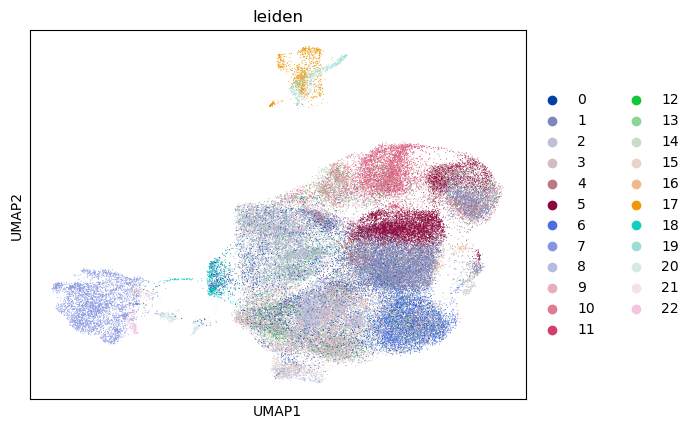

In [29]:
sc.pl.umap(adata, color=[cluster_key])

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

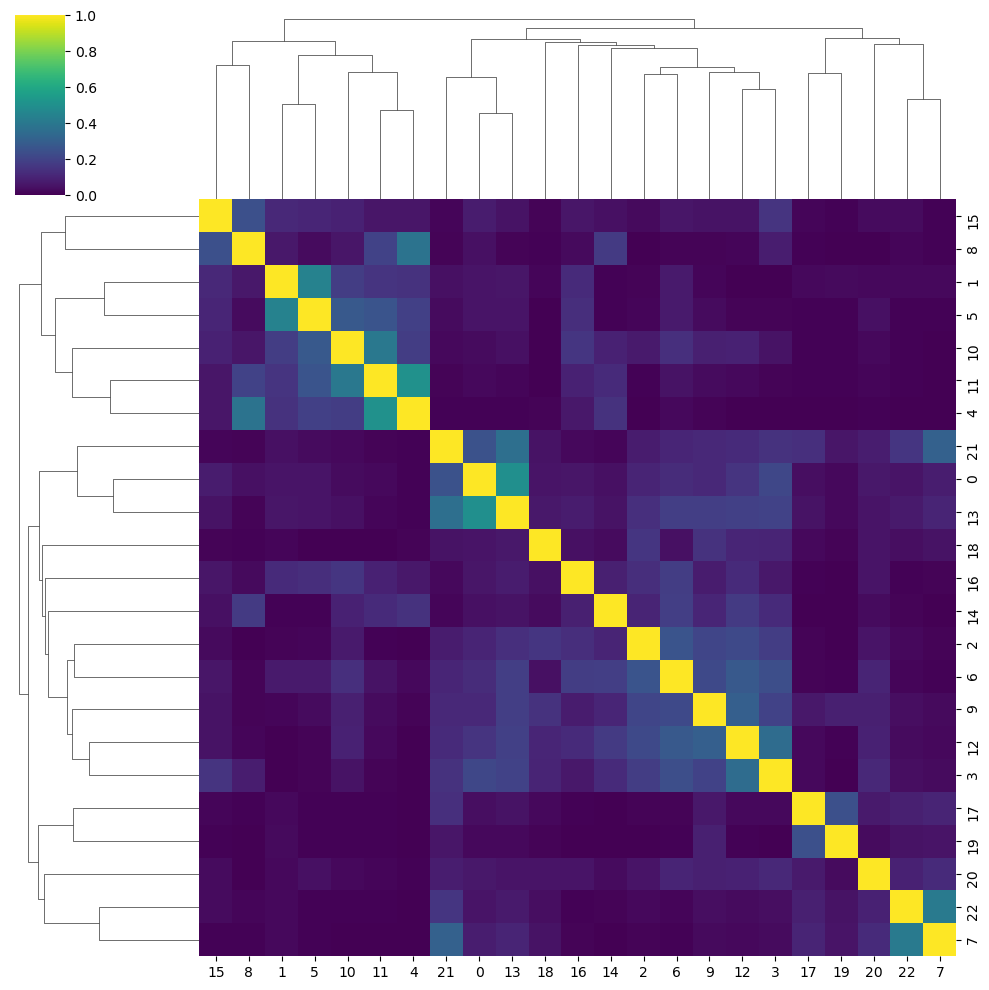

In [31]:
sns.clustermap(J, cmap="viridis")
plt.show()